In [1]:
# Libraries
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
BASE = '/content/'
FILES = [
    '2017-2018 NBA Play-By-Play Data.csv',
    '2018-2019 NBA Play-By-Play Data.csv',
    '2019-2020 NBA Play-By-Play Data.csv'
]
STAR1 = 'Stephen Curry'
STAR2 = 'Kevin Durant'

PATHS = [os.path.join(BASE, f) for f in FILES]
print(f"Config set. Looking for files in: {BASE}")
print(f"Files to load: {FILES}")

Config set. Looking for files in: /content/
Files to load: ['2017-2018 NBA Play-By-Play Data.csv', '2018-2019 NBA Play-By-Play Data.csv', '2019-2020 NBA Play-By-Play Data.csv']


In [5]:
# Load and merge
print("\n=== LOADING FILES ===")
dfs = []
for i, p in enumerate(PATHS, 1):
    print(f"Loading file {i}/{len(PATHS)}: {os.path.basename(p)}...")
    if not os.path.exists(p):
        print(f"WARNING: File not found: {p}")
        continue
    try:
        df_tmp = pd.read_csv(p)
        print(f"Loaded {len(df_tmp):,} rows, {len(df_tmp.columns)} columns")
        df_tmp['season_file'] = os.path.basename(p)
        dfs.append(df_tmp)
    except Exception as e:
        print(f"ERROR loading file: {e}")

if not dfs:
    print("CRITICAL: No files were loaded successfully")
    exit(1)

print(f"\nConcatenating {len(dfs)} dataframes...")
df = pd.concat(dfs, ignore_index=True)
print(f"Total rows loaded: {len(df):,}")
print(f"Columns: {list(df.columns)[:10]}..." if len(df.columns) > 10 else f"Columns: {list(df.columns)}")



=== LOADING FILES ===
Loading file 1/3: 2017-2018 NBA Play-By-Play Data.csv...


/tmp/ipython-input-1364027990.py:10: DtypeWarning: Columns (39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tmp = pd.read_csv(p)


Loaded 369,748 rows, 48 columns
Loading file 2/3: 2018-2019 NBA Play-By-Play Data.csv...


/tmp/ipython-input-1364027990.py:10: DtypeWarning: Columns (40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tmp = pd.read_csv(p)


Loaded 395,745 rows, 46 columns
Loading file 3/3: 2019-2020 NBA Play-By-Play Data.csv...
Loaded 432,481 rows, 46 columns

Concatenating 3 dataframes...
Total rows loaded: 1,197,974
Columns: ['Unnamed: 0', 'game_id', 'data_set', 'date', 'a1', 'a2', 'a3', 'a4', 'a5', 'h1']...


In [6]:
# DIAGNOSTIC:
print("\n=== DIAGNOSING play_length column ===")
print(f"play_length data type: {df['play_length'].dtype}")
print(f"Sample play_length values (first 20):")
print(df['play_length'].head(20).tolist())
print(f"Non-null play_length values: {df['play_length'].notna().sum()}")
print(f"Non-zero play_length values: {(df['play_length'] != 0).sum()}")


=== DIAGNOSING play_length column ===
play_length data type: object
Sample play_length values (first 20):
['00:00:00', '00:00:00', '00:00:17', '00:00:24', '00:00:11', '00:00:06', '00:00:05', '00:00:04', '00:00:05', '00:00:29', '00:00:10', '00:00:00', '00:00:10', '00:00:13', '00:00:22', '00:00:04', '00:00:00', '00:00:06', '00:00:29', '00:00:03']
Non-null play_length values: 1197972
Non-zero play_length values: 1197974


In [7]:
# DF Breakdown
print("\nActual column names in data:")
print(df.columns.tolist())
print("\nColumns containing 'time' or 'clock':")
time_cols = [col for col in df.columns if 'time' in col.lower() or 'clock' in col.lower()]
print(time_cols)


Actual column names in data:
['Unnamed: 0', 'game_id', 'data_set', 'date', 'a1', 'a2', 'a3', 'a4', 'a5', 'h1', 'h2', 'h3', 'h4', 'h5', 'period', 'away_score', 'home_score', 'remaining_time', 'elapsed', 'play_length', 'play_id', 'team', 'event_type', 'assist', 'away', 'home', 'block', 'entered', 'left', 'num', 'opponent', 'outof', 'player', 'points', 'possession', 'reason', 'result', 'steal', 'type', 'shot_distance', 'original_x', 'original_y', 'converted_x', 'converted_y', 'description', 'GameFile', 'Unnamed: 44', 'Unnamed: 45', 'season_file']

Columns containing 'time' or 'clock':
['remaining_time']


In [8]:
# Clean data
print("\n=== CLEANING DATA ===")

# FIRST: Convert play_length from time format (H:MM:SS) to seconds
if 'play_length' in df.columns:
    def parse_play_length(s):
        s = str(s).strip()
        m = re.match(r'^(\d+):(\d{2}):(\d{2})$', s)
        if not m:
            return 0
        hours, mins, secs = int(m.group(1)), int(m.group(2)), int(m.group(3))
        return hours * 3600 + mins * 60 + secs


    df['play_len_sec'] = df['play_length'].apply(parse_play_length)
    print(f"Play lengths converted. Mean: {df['play_len_sec'].mean():.2f} sec")



=== CLEANING DATA ===
Play lengths converted. Mean: 6.18 sec


In [9]:
# THEN: Replace NaN in non-numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in df.columns:
    if col not in numeric_cols:
        df[col] = df[col].fillna('')
print("Replaced NaN values in text columns")

Replaced NaN values in text columns


In [10]:
# Ensure required columns exist
for c in ['GameFile','team','points','time','period','game_id','play_id']:
    if c not in df.columns:
        print(f"Adding missing column: {c}")
        df[c] = ''

Adding missing column: time


In [11]:
# Parse time
print("\n=== PARSING TIME ===")
# Use the existing remaining_time column
if 'remaining_time' in df.columns:
    print("Using existing remaining_time column")
    df['time'] = df['remaining_time']
else:
    print("WARNING: remaining_time column not found")
    df['time'] = ''

def parse_time_to_sec_remaining(s):
    s = str(s).strip()
    m = re.match(r'^(\d{1,2}):(\d{2})$', s)
    if not m:
        return np.nan
    mm, ss = int(m.group(1)), int(m.group(2))
    return mm * 60 + ss

print("Parsing time column...")
df['sec_remaining'] = df['time'].apply(parse_time_to_sec_remaining)
print(f"Time parsed. Non-null values: {df['sec_remaining'].notna().sum():,}")


=== PARSING TIME ===
Using existing remaining_time column
Parsing time column...
Time parsed. Non-null values: 0


In [12]:
# Sort data
print("\n=== SORTING DATA ===")
df['period_num'] = pd.to_numeric(df['period'], errors='coerce').fillna(0).astype(int)
print("Sorting by game_id, period_num, play_id...")
df = df.sort_values(['game_id', 'period_num', 'play_id'])
print("Data sorted")


=== SORTING DATA ===
Sorting by game_id, period_num, play_id...
Data sorted


In [13]:
# Parse team abbreviations
print("\n=== PARSING TEAM ABBREVIATIONS ===")
def parse_teams(gamefile):
    m = re.search(r'([A-Z]{2,4})@([A-Z]{2,4})', str(gamefile))
    if m:
        return m.group(1), m.group(2)
    return '', ''

away_home = df['GameFile'].apply(parse_teams)
df['away_abbr'] = away_home.apply(lambda t: t[0])
df['home_abbr'] = away_home.apply(lambda t: t[1])
print(f"Team abbreviations parsed. Sample: {df['away_abbr'].iloc[0]}@{df['home_abbr'].iloc[0]}")


=== PARSING TEAM ABBREVIATIONS ===
Team abbreviations parsed. Sample: BKN@UTA


In [14]:
# Detect star lineups
print("\n=== DETECTING STAR LINEUPS ===")
LINEUP_COLS = ['a1','a2','a3','a4','a5','h1','h2','h3','h4','h5']
for c in LINEUP_COLS:
    if c not in df.columns:
        print(f"Missing lineup column: {c}")
        df[c] = ''

print(f"Checking for {STAR1} and {STAR2}...")

def stars_state(row):
    lineup = [str(row[c]).strip().lower() for c in LINEUP_COLS]
    has1 = any('stephen' in p and 'curry' in p for p in lineup)
    has2 = any('kevin' in p and 'durant' in p for p in lineup)
    if has1 and has2:
        return 'Together'
    elif has1:
        return 'Solo_Curry'
    elif has2:
        return 'Solo_Durant'
    else:
        return 'Neither'

print("Applying stars_state function...")
df['state'] = df.apply(stars_state, axis=1)
print(f"State calculated. Distribution:")
print(df['state'].value_counts())


=== DETECTING STAR LINEUPS ===
Checking for Stephen Curry and Kevin Durant...
Applying stars_state function...
State calculated. Distribution:
state
Neither        1147427
Together         24743
Solo_Durant      15422
Solo_Curry       10382
Name: count, dtype: int64


In [15]:
# Add this after the "DETECTING STAR LINEUPS" section
print("\n=== DIAGNOSTIC INFO ===")
print("Sample player names from lineup columns:")
for col in ['a1', 'h1']:
    print(f"\n{col} sample values:")
    print(df[col].head(10).tolist())

print("\nChecking for Curry:")
curry_check = df[LINEUP_COLS].apply(lambda x: x.str.contains('curry', case=False, na=False)).any(axis=1)
print(f"Rows with 'curry': {curry_check.sum()}")

print("\nChecking for Durant:")
durant_check = df[LINEUP_COLS].apply(lambda x: x.str.contains('durant', case=False, na=False)).any(axis=1)
print(f"Rows with 'durant': {durant_check.sum()}")

print("\nState distribution:")
print(df['state'].value_counts())


=== DIAGNOSTIC INFO ===
Sample player names from lineup columns:

a1 sample values:
['Timofey Mozgov', 'Timofey Mozgov', 'Timofey Mozgov', 'Timofey Mozgov', 'Timofey Mozgov', 'Timofey Mozgov', 'Timofey Mozgov', 'Timofey Mozgov', 'Timofey Mozgov', 'Timofey Mozgov']

h1 sample values:
['Derrick Favors', 'Derrick Favors', 'Derrick Favors', 'Derrick Favors', 'Derrick Favors', 'Derrick Favors', 'Derrick Favors', 'Derrick Favors', 'Derrick Favors', 'Derrick Favors']

Checking for Curry:
Rows with 'curry': 57570

Checking for Durant:
Rows with 'durant': 40165

State distribution:
state
Neither        1147427
Together         24743
Solo_Durant      15422
Solo_Curry       10382
Name: count, dtype: int64


In [16]:
# Determine team abbreviation
print("\nDetermining team abbreviation...")
def our_team_abbr(row):
    away_lineup = [str(row[c]).lower() for c in ['a1','a2','a3','a4','a5']]
    home_lineup = [str(row[c]).lower() for c in ['h1','h2','h3','h4','h5']]
    if any(('stephen' in p and 'curry' in p) or ('kevin' in p and 'durant' in p) for p in away_lineup):
        return row['away_abbr']
    if any(('stephen' in p and 'curry' in p) or ('kevin' in p and 'durant' in p) for p in home_lineup):
        return row['home_abbr']
    return ''

df['our_team'] = df.apply(our_team_abbr, axis=1)
print(f"Our team identified. Unique teams: {df['our_team'].unique()}")


Determining team abbreviation...
Our team identified. Unique teams: ['' 'GSW']


In [17]:
# Calculate points for and against
print("\n=== CALCULATING POINTS FOR/AGAINST ===")
df['points'] = pd.to_numeric(df.get('points', 0), errors='coerce').fillna(0)
df['team_norm'] = df['team'].astype(str).str.upper().str.strip()

df['for_points'] = np.where(
    (df['state'] != 'Neither') &
    (df['our_team'] != '') &
    (df['team_norm'] == df['our_team'].astype(str).str.upper()),
    df['points'], 0
)

df['against_points'] = np.where(
    (df['state'] != 'Neither') &
    (df['our_team'] != '') &
    (df['team_norm'] != '') &
    (df['team_norm'] != df['our_team'].astype(str).str.upper()),
    df['points'], 0
)

print(f"Points calculated:")
print(f"  Total for_points: {df['for_points'].sum()}")
print(f"  Total against_points: {df['against_points'].sum()}")

print("\n=== PROCESSING COMPLETE ===")
print(f"Final dataframe shape: {df.shape}")



=== CALCULATING POINTS FOR/AGAINST ===
Points calculated:
  Total for_points: 12836.0
  Total against_points: 11884.0

=== PROCESSING COMPLETE ===
Final dataframe shape: (1197974, 60)


In [18]:
# Aggregate by state
print("\n=== AGGREGATING RESULTS BY LINEUP STATE ===")

state_summary = df.groupby('state').agg({
    'play_len_sec': 'sum',
    'for_points': 'sum',
    'against_points': 'sum',
}).reset_index()


=== AGGREGATING RESULTS BY LINEUP STATE ===


In [19]:
# Calculate derived metrics
state_summary['minutes'] = state_summary['play_len_sec'] / 60
state_summary['net_points'] = state_summary['for_points'] - state_summary['against_points']

In [21]:
# Per minute rates
state_summary['pts_for_per_min'] = state_summary['for_points'] / state_summary['minutes']
state_summary['pts_against_per_min'] = state_summary['against_points'] / state_summary['minutes']
state_summary['net_pts_per_min'] = state_summary['net_points'] / state_summary['minutes']
print("\n" + "="*80)
print("LINEUP STATE SUMMARY")
print("="*80)
print(state_summary.to_string(index=False))
print("="*80)


LINEUP STATE SUMMARY
      state  play_len_sec  for_points  against_points       minutes  net_points  pts_for_per_min  pts_against_per_min  net_pts_per_min
    Neither       7095413         0.0             0.0 118256.883333         0.0         0.000000             0.000000         0.000000
 Solo_Curry         62380      2495.0          2420.0   1039.666667        75.0         2.399808             2.327669         0.072139
Solo_Durant         94309      3700.0          3545.0   1571.816667       155.0         2.353964             2.255352         0.098612
   Together        153985      6641.0          5919.0   2566.416667       722.0         2.587655             2.306329         0.281326



=== CREATING VISUALIZATIONS ===


/tmp/ipython-input-1665707754.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(states, rotation=0, ha='center', fontsize=9)
/tmp/ipython-input-1665707754.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(states, rotation=0, ha='center', fontsize=9)
/tmp/ipython-input-1665707754.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(states, rotation=0, ha='center', fontsize=9)


Visualization saved to: /content/curry_durant_analysis.png


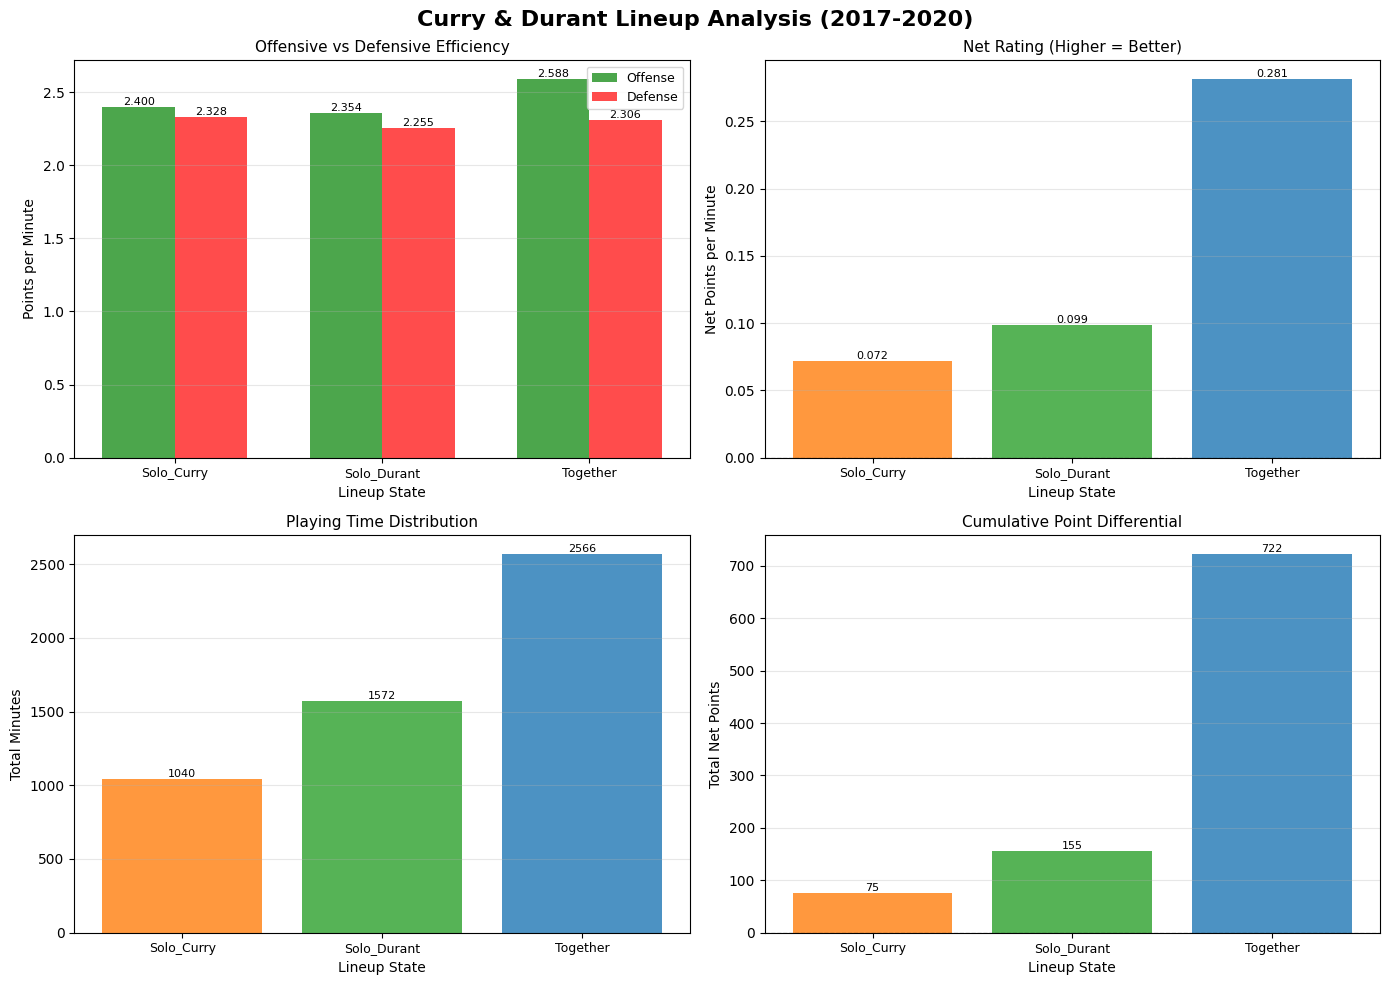

In [25]:
# Visualizations
print("\n=== CREATING VISUALIZATIONS ===")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Curry & Durant Lineup Analysis (2017-2020)', fontsize=16, fontweight='bold')
# Filter out 'Neither' for cleaner comparisons
plot_data = state_summary[state_summary['state'] != 'Neither'].copy()
states = plot_data['state'].tolist()
colors = {'Together': '#1f77b4', 'Solo_Curry': '#ff7f0e', 'Solo_Durant': '#2ca02c'}
bar_colors = [colors.get(s, 'gray') for s in states]
# 1. Points Per Minute (Offensive & Defensive)
ax1 = axes[0, 0]
x = np.arange(len(states))
width = 0.35
bars1 = ax1.bar(x - width/2, plot_data['pts_for_per_min'], width, label='Offense', color='green', alpha=0.7)
bars2 = ax1.bar(x + width/2, plot_data['pts_against_per_min'], width, label='Defense', color='red', alpha=0.7)
ax1.set_xlabel('Lineup State', fontsize=10)
ax1.set_ylabel('Points per Minute', fontsize=10)
ax1.set_title('Offensive vs Defensive Efficiency', fontsize=11)
ax1.set_xticks(x)
ax1.set_xticklabels(states, rotation=0, ha='center', fontsize=9)
ax1.legend(fontsize=9)
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. Net Rating
ax2 = axes[0, 1]
bars = ax2.bar(states, plot_data['net_pts_per_min'], color=bar_colors, alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax2.set_xlabel('Lineup State', fontsize=10)
ax2.set_ylabel('Net Points per Minute', fontsize=10)
ax2.set_title('Net Rating (Higher = Better)', fontsize=11)
ax2.set_xticklabels(states, rotation=0, ha='center', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)

# 3. Total Minutes Distribution
ax3 = axes[1, 0]
bars = ax3.bar(states, plot_data['minutes'], color=bar_colors, alpha=0.8)
ax3.set_xlabel('Lineup State', fontsize=10)
ax3.set_ylabel('Total Minutes', fontsize=10)
ax3.set_title('Playing Time Distribution', fontsize=11)
ax3.set_xticklabels(states, rotation=0, ha='center', fontsize=9)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.0f}', ha='center', va='bottom', fontsize=8)

# 4. Total Net Points
ax4 = axes[1, 1]
bars = ax4.bar(states, plot_data['net_points'], color=bar_colors, alpha=0.8)
ax4.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax4.set_xlabel('Lineup State', fontsize=10)
ax4.set_ylabel('Total Net Points', fontsize=10)
ax4.set_title('Cumulative Point Differential', fontsize=11)
ax4.set_xticklabels(states, rotation=0, ha='center', fontsize=9)
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.0f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(BASE, 'curry_durant_analysis.png'), dpi=300, bbox_inches='tight')
print(f"Visualization saved to: {os.path.join(BASE, 'curry_durant_analysis.png')}")





=== ANALYZING BY QUARTER ===
      state  period_num  play_len_sec  for_points  against_points    minutes  net_points  net_pts_per_min
 Solo_Curry           1         17364       674.0           672.0 289.400000         2.0         0.006911
 Solo_Curry           2         14824       598.0           633.0 247.066667       -35.0        -0.141662
 Solo_Curry           3         16757       689.0           629.0 279.283333        60.0         0.214836
 Solo_Curry           4         13135       526.0           480.0 218.916667        46.0         0.210126
Solo_Durant           1         28690      1119.0          1105.0 478.166667        14.0         0.029278
Solo_Durant           2         21669       872.0           870.0 361.150000         2.0         0.005538
Solo_Durant           3         27511      1088.0           981.0 458.516667       107.0         0.233361
Solo_Durant           4         16361       618.0           585.0 272.683333        33.0         0.121019
   Together     

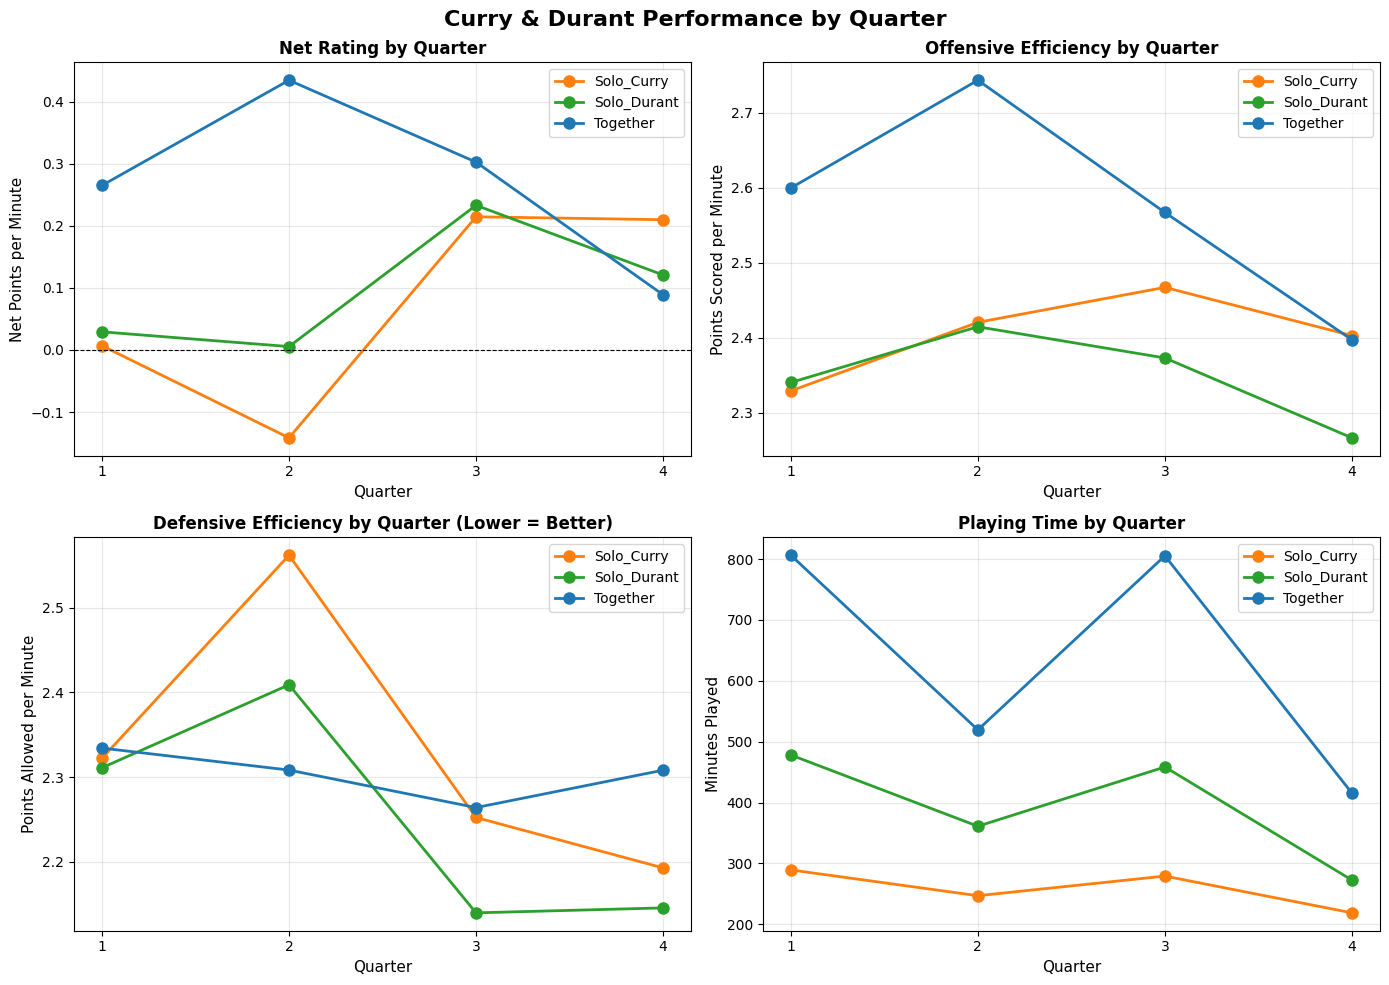

In [26]:
# Additional Analysis: Performance by Quarter
print("\n=== ANALYZING BY QUARTER ===")

# Aggregate by state and period
quarter_summary = df[df['state'] != 'Neither'].groupby(['state', 'period_num']).agg({
    'play_len_sec': 'sum',
    'for_points': 'sum',
    'against_points': 'sum',
}).reset_index()

quarter_summary['minutes'] = quarter_summary['play_len_sec'] / 60
quarter_summary['net_points'] = quarter_summary['for_points'] - quarter_summary['against_points']
quarter_summary['net_pts_per_min'] = quarter_summary['net_points'] / quarter_summary['minutes']

# Filter to regular quarters (1-4, exclude OT)
quarter_summary = quarter_summary[quarter_summary['period_num'].between(1, 4)]

print(quarter_summary.to_string(index=False))

# Create line graph
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))
fig2.suptitle('Curry & Durant Performance by Quarter', fontsize=16, fontweight='bold')

states_list = ['Solo_Curry', 'Solo_Durant', 'Together']
colors_dict = {'Together': '#1f77b4', 'Solo_Curry': '#ff7f0e', 'Solo_Durant': '#2ca02c'}

# 1. Net Rating by Quarter
ax1 = axes2[0, 0]
for state in states_list:
    data = quarter_summary[quarter_summary['state'] == state]
    ax1.plot(data['period_num'], data['net_pts_per_min'],
             marker='o', label=state, color=colors_dict[state], linewidth=2, markersize=8)
ax1.set_xlabel('Quarter', fontsize=11)
ax1.set_ylabel('Net Points per Minute', fontsize=11)
ax1.set_title('Net Rating by Quarter', fontsize=12, fontweight='bold')
ax1.set_xticks([1, 2, 3, 4])
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

# 2. Offensive Efficiency by Quarter
ax2 = axes2[0, 1]
for state in states_list:
    data = quarter_summary[quarter_summary['state'] == state]
    pts_for_per_min = data['for_points'] / data['minutes']
    ax2.plot(data['period_num'], pts_for_per_min,
             marker='o', label=state, color=colors_dict[state], linewidth=2, markersize=8)
ax2.set_xlabel('Quarter', fontsize=11)
ax2.set_ylabel('Points Scored per Minute', fontsize=11)
ax2.set_title('Offensive Efficiency by Quarter', fontsize=12, fontweight='bold')
ax2.set_xticks([1, 2, 3, 4])
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Defensive Efficiency by Quarter
ax3 = axes2[1, 0]
for state in states_list:
    data = quarter_summary[quarter_summary['state'] == state]
    pts_against_per_min = data['against_points'] / data['minutes']
    ax3.plot(data['period_num'], pts_against_per_min,
             marker='o', label=state, color=colors_dict[state], linewidth=2, markersize=8)
ax3.set_xlabel('Quarter', fontsize=11)
ax3.set_ylabel('Points Allowed per Minute', fontsize=11)
ax3.set_title('Defensive Efficiency by Quarter (Lower = Better)', fontsize=12, fontweight='bold')
ax3.set_xticks([1, 2, 3, 4])
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. Minutes Played by Quarter
ax4 = axes2[1, 1]
for state in states_list:
    data = quarter_summary[quarter_summary['state'] == state]
    ax4.plot(data['period_num'], data['minutes'],
             marker='o', label=state, color=colors_dict[state], linewidth=2, markersize=8)
ax4.set_xlabel('Quarter', fontsize=11)
ax4.set_ylabel('Minutes Played', fontsize=11)
ax4.set_title('Playing Time by Quarter', fontsize=12, fontweight='bold')
ax4.set_xticks([1, 2, 3, 4])
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(BASE, 'curry_durant_by_quarter.png'), dpi=300, bbox_inches='tight')
print(f"Quarter analysis saved to: {os.path.join(BASE, 'curry_durant_by_quarter.png')}")

plt.show()